In [65]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [66]:
BASEDIR = Path('.').absolute().parent.parent
DATASDIR = BASEDIR / 'datas'
DATASDIR.mkdir(parents=True, exist_ok=True)

In [67]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cpu')

In [68]:
data = pd.read_csv(DATASDIR / 'GAZP_ME_5Y.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data[data.columns.drop('Date')]
data = data.set_index(['Year', 'Month', 'Day'])

In [69]:
y = data['Close']
X = data[data.columns.drop(['Close', 'Adj Close'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print(f'{X_train.shape=} {X_test.shape=} {y_train.shape=} {y_test.shape=}')

X_train.shape=(879, 4) X_test.shape=(378, 4) y_train.shape=(879,) y_test.shape=(378,)


In [70]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [72]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train.values.reshape(-1,1)).type(torch.Tensor)
y_test = torch.from_numpy(y_test.values.reshape(-1,1)).type(torch.Tensor)

In [73]:
X_train.shape, y_train.shape

(torch.Size([879, 4, 1]), torch.Size([879, 1]))

In [74]:
BATCH_SIZE = 32
LR = 0.001
NUM_EPOCH = 1000

In [75]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [76]:
class RNNNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNNetwork, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, X, h_state):
        out, hidden_state = self.rnn(X, h_state)
        hidden_size = hidden_state[-1].size(-1)
        out = out.view(-1, hidden_size)
        outs = self.out(out)
        return outs, hidden_size

In [77]:
model = RNNNetwork(4, 256, 1, 1)

In [78]:
model

RNNNetwork(
  (rnn): RNN(4, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [79]:
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [80]:
model = model.to(dev)

In [81]:
train_history_loss = []
test_history_loss = []
for epoch in range(NUM_EPOCH):
    train_iters = 0
    train_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(dev), y.to(dev)
        optimizer.zero_grad()

        X = torch.reshape(X, shape=[1, X.shape[0], X.shape[1]])
        y_pred, _ = model(X, h_state=None)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        train_loss += l.item()
        train_iters += 1
    train_history_loss.append(train_loss / train_iters)

    test_iters = 0
    test_loss = 0.0
    for X, y in test_loader:
        X, y = X.to(dev), y.to(dev)
        X = torch.reshape(X, shape=[1, X.shape[0], X.shape[1]])
        y_test_pred, _ = model(X, h_state=None)
        l = loss(y_test_pred, y)
        test_loss += l.item()
        test_iters += 1
    test_history_loss.append(test_loss / test_iters)

    print(f'E: {epoch}, Train loss: {train_loss / train_iters}, Test loss: {test_loss / test_iters}')

 loss: 1.6626792773604393, Test loss: 2280.0354192058244
E: 712, Train loss: 1.5881464193974222, Test loss: 2282.6849088172116
E: 713, Train loss: 1.2116158519472395, Test loss: 2283.548618644476
E: 714, Train loss: 1.2549944179398673, Test loss: 2280.6265453994274
E: 715, Train loss: 1.2078854207481657, Test loss: 2282.43070435524
E: 716, Train loss: 1.1258041188120842, Test loss: 2277.3617523511252
E: 717, Train loss: 1.2618089839816093, Test loss: 2274.6689207951226
E: 718, Train loss: 1.2459403297730856, Test loss: 2270.8919970442853
E: 719, Train loss: 1.451184434550149, Test loss: 2273.260981311401
E: 720, Train loss: 1.3578084600823266, Test loss: 2269.0651509960494
E: 721, Train loss: 1.3089800093855177, Test loss: 2265.211992184321
E: 722, Train loss: 1.1519430662904466, Test loss: 2263.7905224213996
E: 723, Train loss: 1.063348877642836, Test loss: 2260.6906987180314
E: 724, Train loss: 1.0937992568526949, Test loss: 2257.7055276980004
E: 725, Train loss: 1.3716876921909196, 

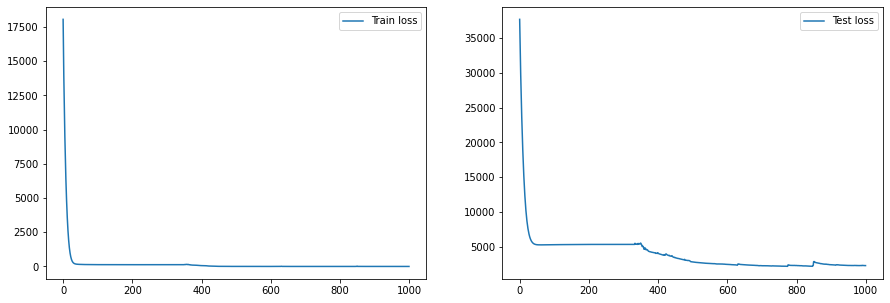

In [82]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(train_history_loss, label='Train loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_history_loss, label='Test loss')
plt.legend()


plt.show()

In [83]:
train_df = pd.DataFrame(y_train.detach().numpy())
test_df = pd.DataFrame(y_test.detach().numpy())
train_test_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [84]:
X_train = torch.reshape(X_train, shape=[1, X_train.shape[0], X_train.shape[1]])
X_test = torch.reshape(X_test, shape=[1, X_test.shape[0], X_test.shape[1]])
X_train.shape, X_test.shape

(torch.Size([1, 879, 4]), torch.Size([1, 378, 4]))

In [85]:
train_predict_df = pd.DataFrame(model(X_train.to(dev), h_state=None)[0].cpu().detach().numpy())
test_predict_df = pd.DataFrame(model(X_test.to(dev), h_state=None)[0].cpu().detach().numpy())
train_test_predict_df = pd.concat([train_predict_df, test_predict_df]).reset_index(drop=True)

In [86]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_test_df[:train_df.size].index, y=train_test_df[:train_df.size][0], mode='lines', name='Train Data'))
fig.add_trace(go.Scatter(x=train_test_df[train_df.size:].index, y=train_test_df[train_df.size:][0], mode='lines', name='Test Data'))
fig.add_trace(go.Scatter(x=train_test_predict_df[:train_predict_df.size].index, y=train_test_predict_df[:train_predict_df.size][0], mode='lines', name='Train Predict Data'))
fig.add_trace(go.Scatter(x=train_test_predict_df[train_predict_df.size:].index, y=train_test_predict_df[train_predict_df.size:][0], mode='lines', name='Test Predict Data'))

fig.show()

In [87]:
MODELSDIR = BASEDIR / 'models'
MODELSDIR.mkdir(parents=True, exist_ok=True)

In [88]:
model.eval()
if 'sgd' in str(optimizer).lower():
    torch.save(model.state_dict(), MODELSDIR / 'RNN_SGD.pt')
elif 'adam' in str(optimizer).lower():
    torch.save(model.state_dict(), MODELSDIR / 'RNN_Adam.pt')